# Retweet Network Analysis

python=3.7

|topic      |platform   |language   |
|-----------|-----------|-----------|
|POTUS2020  |Twitter    |en         |

In [ ]:
import pandas as pd
import networkx as nx
import seaborn as sns
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

name_suffix = "[v3][debunking=keywords][lang=en][topic=POTUS2020][platform=Twitter]"

## 1 Build a retweet network (without media filtering)

In [3]:
df = pd.read_csv(f"data/full_data{name_suffix}.csv")
df.shape

(6608464, 83)

In [ ]:

df_rt = df[df['referenced_tweets.retweeted.id'].notnull()]
df_rt.to_csv(f"data/retweet{name_suffix}.csv", index=False)
print(f"number of retweets: {df_rt.shape[0]}")


edge_list = pd.concat(axis=1, objs=[df_rt['author.username'],df_rt['retweeted_username'],df_rt['id']])
edge_list.columns = ['source','target','label']

D = nx.from_pandas_edgelist(edge_list, create_using=nx.DiGraph, edge_attr='label')  # 利用边的信息来构建有向图
#nx.write_gexf(D, f"data/RTnetworks{name_suffix}.gexf") 

In [3]:
D = nx.read_gexf(f"data/RTnetworks{name_suffix}.gexf")
nx.write_gexf(D, f"/mnt/data/Sentiment_results/wenlu/2core+not2core_users/POTUS2020/RTnetworks{name_suffix}.gexf")  # 保存有向图数据

In [ ]:
D = nx.read_gexf(f"data/RTnetworks{name_suffix}.gexf")
D.remove_edges_from(nx.selfloop_edges(D))

k_core_2 = nx.k_core(D, k=2, core_number=None)

subgraph = D.copy()
subgraph.remove_nodes_from(k_core_2.nodes())
nx.write_gexf(subgraph, f"/mnt/data/Sentiment_results/wenlu/2core+not2core_users/POTUS2020/RTnetworks[none_2core]{name_suffix}.gexf")  # 保存有向图数据
nx.write_gexf(k_core_2, f"/mnt/data/Sentiment_results/wenlu/2core+not2core_users/POTUS2020/RTnetworks[core=2]{name_suffix}.gexf")


In [5]:
# 2-core subgraph
D = nx.read_gexf(f"data/RTnetworks{name_suffix}.gexf")
D.remove_edges_from(nx.selfloop_edges(D))
D2 = nx.k_core(D, k=2, core_number=None)
print(f"number of nodes: {D2.number_of_nodes()}")
print(f"number of edges: {D2.number_of_edges()}")
nx.write_gexf(D2, f"data/RTnetworks[core=2]{name_suffix}.gexf")

number of nodes: 450872
number of edges: 3300628


## 2 Wash the retweet text

In [ ]:
# # Combine each user's own text
df_txt = df_rt
df_txt['text'] = df_txt['text'].astype(str)
user_texts = df_txt.groupby(by='author.username').agg(text=("text", lambda x: " ".join(set(x))))
user_texts.reset_index(drop=False, inplace=True)
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   author.username  1007206 non-null  object
 1   text             1007206 non-null  object
dtypes: object(2)
memory usage: 15.4+ MB


### 2.1 Only the HTML tags and URLs are removed

In [ ]:
import html
def simple_text_cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = html.unescape(text)  
    text = re.sub(r'<.*?>+', '', text) 
    return text

In [8]:
df_txt = user_texts

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)
df_txt['text_simply_cleaned'] = df_txt['text'].parallel_apply(simple_text_cleaning)

user_texts = df_txt

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 2.2 save

In [9]:
user_texts.to_csv(f"data/user_texts{name_suffix}.csv", index=False)
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   author.username      1007206 non-null  object
 1   text                 1007206 non-null  object
 2   text_simply_cleaned  1007206 non-null  object
dtypes: object(3)
memory usage: 23.1+ MB


## 3 Perspective API

In [ ]:

# user_texts = pd.read_csv(f"data/user_texts{name_suffix}.csv")
texts = pd.DataFrame(user_texts['text_simply_cleaned'].drop_duplicates())
texts = texts.rename(columns={'text_simply_cleaned': 'text'})
texts.to_csv(f"data/user_texts_no_duplicates{name_suffix}.csv", index=False)
print(f"number of texts: {len(texts)}")

number of texts: 460230


In [ ]:
texts = pd.read_csv(f"data/toxicity_of_user_texts_no_duplicates{name_suffix}.csv")

def get_score_from_json(x):

    if pd.isna(x) or not x:
        return None
    s = re.search("'score': {'value': (.+?),", x)
    return float(s.group(1))

texts['toxicity'] = texts['perspective_api_results'].apply(get_score_from_json)
texts.to_csv(f"data/toxicity_of_user_texts_no_duplicates{name_suffix}.csv", index=False)


texts.index = texts['text']
score_dict = dict(pd.Series(texts['toxicity']))

user_texts = pd.read_csv(f"data/user_texts{name_suffix}.csv")
user_texts['toxicity'] = user_texts['text_simply_cleaned'].map(score_dict)
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   author.username      1007206 non-null  object 
 1   text                 1007206 non-null  object 
 2   text_simply_cleaned  1007206 non-null  object 
 3   toxicity             1003580 non-null  float64
dtypes: float64(1), object(3)
memory usage: 30.7+ MB


## 4 NLTK

In [ ]:

# import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk_analyzer = SentimentIntensityAnalyzer()

example = nltk_analyzer.polarity_scores("")
sentiment_names = list(example.keys())
print(sentiment_names)

['neg', 'neu', 'pos', 'compound']


In [ ]:

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)

# user_texts.drop(columns=sentiment_names, inplace=True)

result = user_texts['text_simply_cleaned'].astype(str).parallel_apply(nltk_analyzer.polarity_scores)
result = pd.DataFrame(result.tolist())

user_texts = pd.concat([user_texts, result], axis=1)
user_texts.to_csv(f"data/user_texts{name_suffix}.csv", index=False)
user_texts.info()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   author.username      1007206 non-null  object 
 1   text                 1007206 non-null  object 
 2   text_simply_cleaned  1007206 non-null  object 
 3   toxicity             1003580 non-null  float64
 4   neg                  1007206 non-null  float64
 5   neu                  1007206 non-null  float64
 6   pos                  1007206 non-null  float64
 7   compound             1007206 non-null  float64
dtypes: float64(5), object(3)
memory usage: 61.5+ MB


## 5 Sentiment and toxicity analysis

In [ ]:
# draw 2D kernel density heatmap
import numpy as np
import plotly.graph_objects as go
from scipy.stats import kde

def toxi_senti_heatmap_2d_ver4(
        data:pd.DataFrame, 
        x='toxicity', 
        y='compound',
        xlim=(0, 1), 
        ylim=(-1, 1),
        zlim=(None, None),
        z_scaling=False,
        density_mul_count=True,
        nbins=200
    ):
    
    data = data[data[x].notna() & data[y].notna()]   
   
    _x = data[x]
    _y = data[y]
    k = kde.gaussian_kde([_x,_y])
    xi, yi = np.mgrid[
            xlim[0]:xlim[1]:nbins*1j, 
            ylim[0]:ylim[1]:nbins*1j
        ]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    if density_mul_count:
        zi = zi * len(data)
    elif z_scaling:
        zi = (zi - zi.min()) * (zlim[1] - zlim[0]) / (zi.max() - zi.min()) + zlim[0]

  
    fig = go.Figure(data=go.Heatmap(
        x=xi.flatten(),
        y=yi.flatten(),
        z=zi, zmin=zlim[0], zmax=zlim[1],
        colorscale='Turbo',
        colorbar=dict(thickness=25, len=0.75, tickfont=dict(size=11))
    ))

  
    fig.update_layout(
        autosize=False,
        width=450,
        height=370,
        margin=dict(l=0, r=0, b=45, t=0),
        plot_bgcolor='white',  
        xaxis_showgrid=False,  
        yaxis_showgrid=False,  
    )
    axis_title_size = 16
    axis_tick_size = 12
    fig.update_xaxes(
        title=dict(
                text=x.title() + ' score',
                font=dict(size=axis_title_size),
                standoff=8
            ),
        range=xlim,
        tickfont=dict(size=axis_tick_size), 
        linecolor='black',
        linewidth=0
    )
    fig.update_yaxes(
        title=dict(
                text=y.title() + ' score',
                font=dict(size=axis_title_size),
                standoff=5
            ),
        range=ylim,
        tickfont=dict(size=axis_tick_size), 
        linecolor='black',
        linewidth=0
    )
    return fig, xi, yi, zi

In [ ]:
# draw 3D kernel density heatmap
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import plotly.io as pio


def toxi_senti_heatmap_3d_ver4(
        df:pd.DataFrame, 
        x='toxicity', 
        y='compound',
        xlim=(0, 1), 
        ylim=(-1, 1),
        zlim=(None, None),
        density_mul_count=True,
        title=None,
        nbins=100
    ):
    
    df = df[df[x].notna() & df[y].notna()]   
    data = np.vstack([df[x].values, df[y].values])

    
    kde = gaussian_kde(data)


    xgrid = np.linspace(xlim[0], xlim[1], nbins)
    ygrid = np.linspace(ylim[0], ylim[1], nbins)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    Z = Z * len(df) if density_mul_count else Z

    
    fig = go.Figure(data=[go.Surface(
                x=Xgrid, 
                y=Ygrid, 
                z=Z.reshape(Xgrid.shape), cmin=zlim[0], cmax=zlim[1], 
                colorscale='Turbo', 
                colorbar=dict(thickness=25, len=0.618, tickfont=dict(size=11)))
            ])

   
    if title:
        fig.update_layout(
                title=dict(x=0.5, y=0.97, font=dict(size=22), text=title, ),
                autosize=False,
                width=450, height=400,
                margin=dict(l=0, r=0, b=0, t=30), 
        )
    else: 
        fig.update_layout(
                autosize=False,
                width=450, height=370,
                margin=dict(l=0, r=0, b=0, t=0), 
        )
    axis_title_size = 14
    axis_tick_size = 11
    fig.update_scenes(
        xaxis=dict(
            title=dict(
                text=x.title() + ' score',
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
        ),
        yaxis=dict(
            title=dict(
                text=y.title() + ' score',
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
        ),
        zaxis=dict(
            title=dict(
                text='Kernel density',
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
            range=[zlim[0], zlim[1]]
        ),
        camera=dict(
            center=dict(x=0, y=0.20, z=0.02),
            eye=dict(x=-12, y=8, z=7),
            projection=dict(type="orthographic"),
        ),
        aspectratio=dict(x=1.28, y=1.28, z=1.28),
    )
    
    return fig, (Z.min(), Z.max())

### There are three types of user ranges

The number of users of the three types

In [ ]:

user_texts = pd.read_csv(f"data/user_texts{name_suffix}.csv")
print(f"number of all users: {len(user_texts)}")

D2 = nx.read_gexf(f"data/RTnetworks[core=2]{name_suffix}.gexf")
nodes_2core = nx.get_node_attributes(D2, 'label')


user_texts_2core = user_texts[user_texts['author.username'].isin(nodes_2core)]
print(f"number of 2-core users: {len(user_texts_2core)}", 
      f"({100 * len(user_texts_2core) / len(user_texts)}%)")


user_texts_no_2core = user_texts[ ~ user_texts['author.username'].isin(nodes_2core)]
print(f"number of non-2-core users: {len(user_texts_no_2core)}", 
      f"({100 * len(user_texts_no_2core) / len(user_texts)}%)")

number of all users: 1007206
number of 2-core users: 440393 (43.7242232472801%)
number of non-2-core users: 566813 (56.2757767527199%)


***2 core ***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks


data = user_texts_2core


toxicity_scores = data['toxicity'].dropna().values
compound_scores = data['compound'].dropna().values


In [ ]:
from diptest import diptest
# Hartigan's Dip Test
dip_statistic, p_value = diptest(compound_scores)


print(f'Hartigan\'s Dip Test Statistic: {dip_statistic}')
print(f'P-value: {p_value}')


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Evidence of multimodality.")
else:
    print("Fail to reject the null hypothesis: No evidence of multimodality.")


Hartigan's Dip Test Statistic: 0.053637183364369255
P-value: 0.0
Reject the null hypothesis: Evidence of multimodality.


In [ ]:

# Hartigan's Dip Test
dip_statistic, p_value = diptest(toxicity_scores)


print(f'Hartigan\'s Dip Test Statistic: {dip_statistic}')
print(f'P-value: {p_value}')


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Evidence of multimodality.")
else:
    print("Fail to reject the null hypothesis: No evidence of multimodality.")

Hartigan's Dip Test Statistic: 0.022642407875407097
P-value: 0.0
Reject the null hypothesis: Evidence of multimodality.


***1 degree***

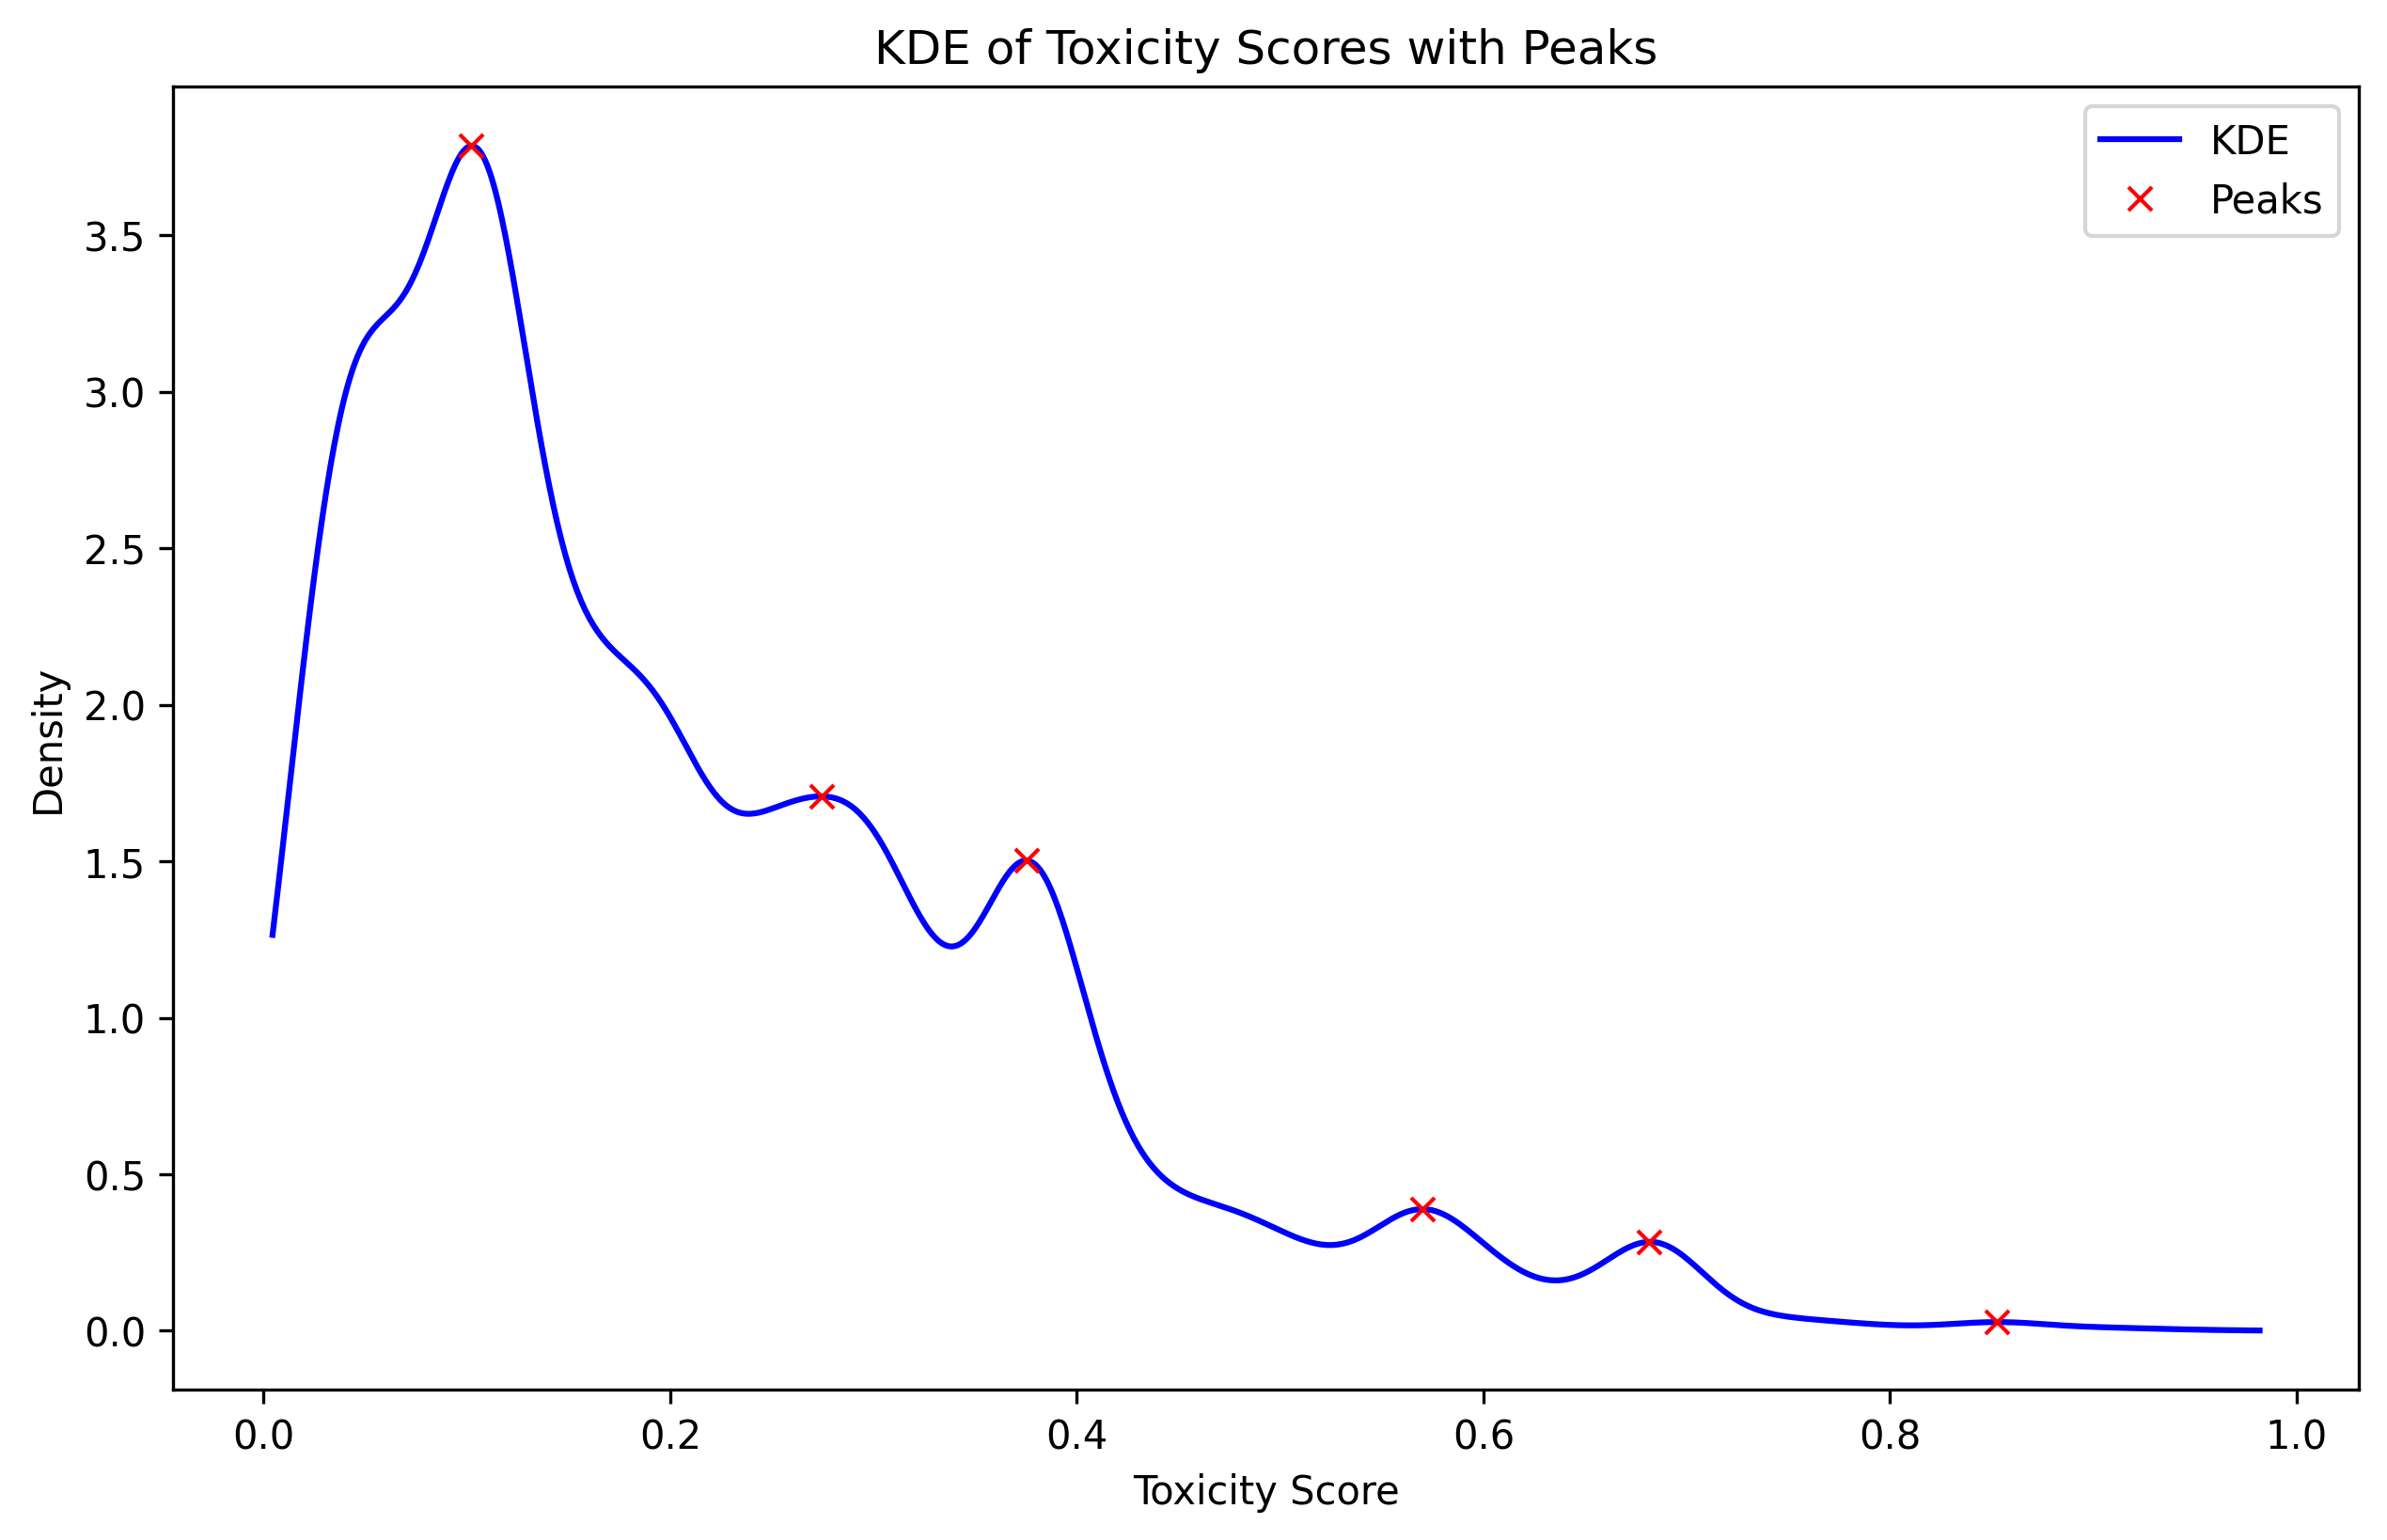

Number of peaks found: 6
Peak values: [3.78530166 1.70737696 1.50228364 0.38877269 0.28414304 0.0278611 ]
Peak positions: [0.10223243 0.27442082 0.37519016 0.56988045 0.68141156 0.85262161]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks


data = user_texts_no_2core


toxicity_scores = data['toxicity'].dropna().values
compound_scores = data['compound'].dropna().values


In [ ]:
from diptest import diptest
# Hartigan's Dip Test
dip_statistic, p_value = diptest(compound_scores)


print(f'Hartigan\'s Dip Test Statistic: {dip_statistic}')
print(f'P-value: {p_value}')


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Evidence of multimodality.")
else:
    print("Fail to reject the null hypothesis: No evidence of multimodality.")


Hartigan's Dip Test Statistic: 0.053637183364369255
P-value: 0.0
Reject the null hypothesis: Evidence of multimodality.


In [ ]:

# Hartigan's Dip Test
dip_statistic, p_value = diptest(toxicity_scores)


print(f'Hartigan\'s Dip Test Statistic: {dip_statistic}')
print(f'P-value: {p_value}')


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Evidence of multimodality.")
else:
    print("Fail to reject the null hypothesis: No evidence of multimodality.")

Hartigan's Dip Test Statistic: 0.022642407875407097
P-value: 0.0
Reject the null hypothesis: Evidence of multimodality.


In [3]:
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   author.username      1007206 non-null  object 
 1   text                 1007206 non-null  object 
 2   text_simply_cleaned  1007206 non-null  object 
 3   toxicity             1003580 non-null  float64
 4   neg                  1007206 non-null  float64
 5   neu                  1007206 non-null  float64
 6   pos                  1007206 non-null  float64
 7   compound             1007206 non-null  float64
dtypes: float64(5), object(3)
memory usage: 61.5+ MB


In [4]:
user_texts['core_status'] = user_texts['author.username'].apply(lambda x: '2 core' if x in nodes_2core else '1 degree')

In [5]:
user_texts2 = user_texts[['author.username', 'core_status']]
user_texts2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   author.username  1007206 non-null  object
 1   core_status      1007206 non-null  object
dtypes: object(2)
memory usage: 15.4+ MB


In [ ]:
df_right_left = pd.read_csv("/mnt/data/wenlu/Classification-of-political-affiliation/core2_right_left_2classes.csv")
mapping_dict = df_right_left.set_index('Id')['modularity_class'].to_dict()


user_texts2['party'] = user_texts2['author.username'].map(mapping_dict)

user_texts2['party'] = user_texts2['party'].replace({1: 'Democrats', 74: 'Republicans'})
user_texts2.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   author.username  1007206 non-null  object
 1   core_status      1007206 non-null  object
 2   party            295351 non-null   object
dtypes: object(3)
memory usage: 23.1+ MB


In [7]:
user_texts2.to_csv(f"/mnt/data/Sentiment_results/wenlu/user_kcore_party_info/Twitter/user[core_info][party_info]{name_suffix}.csv", index = False)

In [3]:
df_2020 = pd.read_csv("/mnt/data/wenlu/two-party-sanky/POTU2020_Twitter/sentiment_urls/data/user_texts_[LLMsentiment][debunking=keywords][lang=en][topic=POTUS2020][platform=Twitter][9.5].csv")
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007206 entries, 0 to 1007205
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   author.username      1007206 non-null  object 
 1   text                 1007206 non-null  object 
 2   text_simply_cleaned  1007206 non-null  object 
 3   toxicity             1003580 non-null  float64
 4   neg                  1007206 non-null  float64
 5   neu                  1007206 non-null  float64
 6   pos                  1007206 non-null  float64
 7   compound             1007206 non-null  float64
 8   anger                1007206 non-null  float64
 9   anticipation         1007206 non-null  float64
 10  disgust              1007206 non-null  float64
 11  fear                 1007206 non-null  float64
 12  joy                  1007206 non-null  float64
 13  love                 1007206 non-null  float64
 14  optimism             1007206 non-null  float64
 15

In [5]:
pessi_dict = df_2020.set_index('author.username')['pessimism'].to_dict()
user_texts['pessimism'] = user_texts['author.username'].map(pessi_dict)
user_texts_2core['pessimism'] = user_texts_2core['author.username'].map(pessi_dict)
user_texts_no_2core['pessimism'] = user_texts_no_2core['author.username'].map(pessi_dict)

### Differential test of the combined distribution of emotion-toxicity in the three types of users

In [6]:
from scipy.stats import mannwhitneyu
def Mann_Whitney_U_test(srs1:pd.Series, srs2:pd.Series):
    '''Perform the Mann-Whitney U test.'''
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='less')
    if p_value < 0.05:
        print(f"U-statistic: {u_statistic}, P-Value: {p_value}", end=', ')
        print('The former is significantly smaller overall than the latter.')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='greater')
    if p_value < 0.05:
        print(f"U-statistic: {u_statistic}, P-Value: {p_value}", end=', ')
        print('The former is significantly larger overall than the latter.')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='two-sided')
    print(f"U-statistic: {u_statistic}, P-Value: {p_value}", end=', ')
    if p_value < 0.05:
        print('There is a significant difference between the two sets of data.')
    else:
        print('There is no significant difference between the two sets of data.')


from scipy.stats import ttest_ind
def t_test(srs1:pd.Series, srs2:pd.Series):
    '''t test'''
    t_statistic, p_value = ttest_ind(srs1, srs2)
    print(f"T-statistic: {t_statistic}, P-Value: {p_value}", end=', ')
    if p_value < 0.05:
        if t_statistic > 0:
            print('The mean of the former is significantly larger than that of the latter.')
        else:
            print('The mean of the former is significantly smaller than that of the latter.')
    else:
        print('There is no significant difference between the two sets of data.')

In [ ]:
_all = user_texts[user_texts['toxicity'].notna() & user_texts['compound'].notna()]
_2core = user_texts_2core[user_texts_2core['toxicity'].notna() & user_texts_2core['compound'].notna()]
_non_2core = user_texts_no_2core[user_texts_no_2core['toxicity'].notna() & user_texts_no_2core['compound'].notna()]


data1 = _all.loc[:, ['toxicity','compound','pessimism']]
data2 = _2core.loc[:, ['toxicity','compound','pessimism']]
data3 = _non_2core.loc[:, ['toxicity','compound','pessimism']]

Mann-Whitney U test

In [9]:
print("Toxicity：")
print("all vs 2-core: ", end='\t\t')
Mann_Whitney_U_test(data1['toxicity'], data2['toxicity'])
print("all vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data1['toxicity'], data3['toxicity'])
print("2-core vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data2['toxicity'], data3['toxicity'])

print()

print("Sentiment：")
print("all vs 2-core: ", end='\t\t')
Mann_Whitney_U_test(data1['compound'], data2['compound'])
print("all vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data1['compound'], data3['compound'])
print("2-core vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data2['compound'], data3['compound'])

毒性：
all vs 2-core: 		U统计量: 169635598131.5, P值: 0.0, 前者整体显著比后者小。
all vs non-2-core: 	U统计量: 333950810068.5, P值: 0.0, 前者整体显著比后者大。
2-core vs non-2-core: 	U统计量: 173555958724.0, P值: 0.0, 前者整体显著比后者大。

情感：
all vs 2-core: 		U统计量: 268800119302.0, P值: 0.0, 前者整体显著比后者大。
all vs non-2-core: 	U统计量: 234786288898.0, P值: 0.0, 前者整体显著比后者小。
2-core vs non-2-core: 	U统计量: 74391437553.5, P值: 0.0, 前者整体显著比后者小。


In [8]:
data1 = data1[data1['pessimism'].notna()]
data2 = data2[data2['pessimism'].notna()]
data3 = data3[data3['pessimism'].notna()]

print("Pessimism：")
print("all vs 2-core: ", end='\t\t')
Mann_Whitney_U_test(data1['pessimism'], data2['pessimism'])
print("all vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data1['pessimism'], data3['pessimism'])
print("2-core vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data2['pessimism'], data3['pessimism'])

悲观情绪：
all vs 2-core: 		U统计量: 225741568904.0, P值: 2.5005230892892488e-169, 前者整体显著比后者大。
all vs non-2-core: 	U统计量: 277844839296.0, P值: 1.2576532449105387e-120, 前者整体显著比后者小。
2-core vs non-2-core: 	U统计量: 117449987951.5, P值: 0.0, 前者整体显著比后者小。


t test

In [10]:
print("Toxicity：")
print("all vs 2-core: ", end='\t\t')
t_test(data1['toxicity'], data2['toxicity'])
print("all vs non-2-core: ", end='\t')
t_test(data1['toxicity'], data3['toxicity'])
print("2-core vs non-2-core: ", end='\t')
t_test(data2['toxicity'], data3['toxicity'])

print()

print("Sentiment：")
print("all vs 2-core: ", end='\t\t')
t_test(data1['compound'], data2['compound'])
print("all vs non-2-core: ", end='\t')
t_test(data1['compound'], data3['compound'])
print("2-core vs non-2-core: ", end='\t')
t_test(data2['compound'], data3['compound'])

毒性：
all vs 2-core: 		T统计量: -188.63948036771578, P值: 0.0, 前者平均值显著比后者的小。
all vs non-2-core: 	T统计量: 144.01092090038995, P值: 0.0, 前者平均值显著比后者的大。
2-core vs non-2-core: 	T统计量: 293.3053860412453, P值: 0.0, 前者平均值显著比后者的大。

情感：
all vs 2-core: 		T统计量: 140.90030505644398, P值: 0.0, 前者平均值显著比后者的大。
all vs non-2-core: 	T统计量: -126.10741787424149, P值: 0.0, 前者平均值显著比后者的小。
2-core vs non-2-core: 	T统计量: -236.0792908598128, P值: 0.0, 前者平均值显著比后者的小。


### High-density point judgment function and screening function

In [ ]:
def isCloseToHighDensity(
        row, 
        high_density_coords, 
        x='toxicity',
        y='compound',
        xlim=(0, 1),
        ylim=(-1, 1),
        nbins=200
    ):

    threshold = dict(x = (xlim[1]-xlim[0]) / (nbins-1) / 2, y = (ylim[1]-ylim[0]) / (nbins-1) / 2)

    close_to_high_density = high_density_coords[
        (
            (high_density_coords['x'] - threshold['x'] <= row[x]) &
            (row[x] <= high_density_coords['x'] + threshold['x'])
        ) &
        (
            (high_density_coords['y'] - threshold['y'] <= row[y]) &
            (row[y] <= high_density_coords['y'] + threshold['y'])
        )
    ]
    return not(close_to_high_density.empty)

def findHighDensityPoints(
        data: pd.DataFrame,
        density_dist: dict,
        x='toxicity',
        y='compound',
        xlim=(0, 1),
        ylim=(-1, 1),
        threshold = 0.8,
        nbins=200,
        progress_bar=False,
        nb_workers=20
    ):

    indices = np.where(density_dist['z'] > threshold)


    high_density_x_coords = density_dist['x'].flatten()[indices]
    high_density_y_coords = density_dist['y'].flatten()[indices]


    high_density_coords = dict(x=[], y=[])
    for _x, _y in zip(high_density_x_coords, high_density_y_coords):
        high_density_coords['x'].append(_x)
        high_density_coords['y'].append(_y)

    high_density_coords = pd.DataFrame(high_density_coords)


    from pandarallel import pandarallel
    pandarallel.initialize(progress_bar=progress_bar, nb_workers=nb_workers)

    high_density_points = data[data.parallel_apply(isCloseToHighDensity, 
                                                    args=(
                                                            high_density_coords, 
                                                            x, y,
                                                            xlim, ylim,
                                                            nbins
                                                        ), 
                                                    axis=1)]
    print(f"The number of high-density points: {len(high_density_points)}", end=', ')
    print(f"Percentage of users in this category:{100 * len(high_density_points) / len(data)}")

    return high_density_points

### **5.1 All retweet users**

#### 5.1.1 

In [ ]:
sns.displot(user_texts, x='toxicity', height=6, aspect=8/6)
plt.xlabel('toxicity'.title() + ' score')
plt.savefig(f"pic/toxicity{name_suffix}.png")

In [ ]:
sns.displot(user_texts, x='compound', height=6, aspect=8/6)
plt.xlabel('compound'.title() + ' score')
plt.savefig(f"pic/compound{name_suffix}.png")

#### 5.1.2 Toxicity-Compound

In [ ]:
fig, zlim_3d = toxi_senti_heatmap_3d_ver4(user_texts)
# fig.show()

pio.write_image(
    fig, 
    f'pic/heatmap[dim=3][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

In [ ]:
fig, _, _, zs_2d = toxi_senti_heatmap_2d_ver4(user_texts)
# fig.show()

pio.write_image(
    fig, 
    f'pic/heatmap[dim=2][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

#### 5.1.3  Combined Z-axis normalized probability distributions

In [ ]:
fig, xs, ys, zs = toxi_senti_heatmap_2d_ver4(
                        user_texts, 
                        zlim=(0, 1), 
                        z_scaling=True, 
                        density_mul_count=False
                    )
# fig.show()
pio.write_image(
    fig, 
    f'pic/z_scaled_heatmap[dim=2][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)


hd_all = findHighDensityPoints(user_texts, dict(x=xs, y=ys, z=zs))
hd_all.to_csv(f"data/high_density_users{name_suffix}.csv")

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
高密度点的数量: 73545, 在此类用户中的占比：7.30188263374126


### **5.2 2-core retweet users**

#### 5.2.1 

In [ ]:
sns.displot(user_texts_2core, x='toxicity', height=6, aspect=8/6)
plt.xlabel('toxicity'.title() + ' score')
plt.savefig(f"pic/toxicity[core=2]{name_suffix}.png")

In [ ]:
sns.displot(user_texts_2core, x='compound', height=6, aspect=8/6)
plt.xlabel('compound'.title() + ' score')
plt.savefig(f"pic/compound[core=2]{name_suffix}.png")

#### 5.2.2 Toxicity-Compound

In [ ]:
fig, _ = toxi_senti_heatmap_3d_ver4(user_texts_2core, zlim=zlim_3d)
# fig.show()
pio.write_image(
    fig, 
    f'pic/heatmap[dim=3][core=2][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

In [ ]:
fig, _, _, _ = toxi_senti_heatmap_2d_ver4(user_texts_2core, zlim=(zs_2d.min(), zs_2d.max()))
# fig.show()

pio.write_image(
    fig, 
    f'pic/heatmap[dim=2][core=2][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

#### 5.2.3  Combined Z-axis normalized probability distributions

In [ ]:
fig, xs, ys, zs = toxi_senti_heatmap_2d_ver4(
                        user_texts_2core, 
                        zlim=(0, 1), 
                        z_scaling=True, 
                        density_mul_count=False
                    )
# fig.show()
pio.write_image(
    fig, 
    f'pic/z_scaled_heatmap[dim=2][core=2][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)


hd_2core = findHighDensityPoints(user_texts_2core, dict(x=xs, y=ys, z=zs))
hd_2core.to_csv(f"data/high_density_users[core=2]{name_suffix}.csv")

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
高密度点的数量: 70132, 在此类用户中的占比：15.924867107333677


### **5.3 Remove 2-core users**

#### 5.3.1 

In [ ]:
sns.displot(user_texts_no_2core, x='toxicity', height=6, aspect=8/6)
plt.xlabel('toxicity'.title() + ' score')
plt.savefig(f"pic/toxicity[core=no_2core]{name_suffix}.png")

In [ ]:
sns.displot(user_texts_no_2core, x='compound', height=6, aspect=8/6)
plt.xlabel('compound'.title() + ' score')
plt.savefig(f"pic/compound[core=no_2core]{name_suffix}.png")

#### 5.3.2 Toxicity-Compound

In [ ]:
fig, _ = toxi_senti_heatmap_3d_ver4(user_texts_no_2core, zlim=zlim_3d)
# fig.show()
pio.write_image(
    fig, 
    f'pic/heatmap[dim=3][core=no_2core][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

In [ ]:
fig, _, _, _ = toxi_senti_heatmap_2d_ver4(user_texts_no_2core, zlim=(zs_2d.min(), zs_2d.max()))
# fig.show()
pio.write_image(
    fig, 
    f'pic/heatmap[dim=2][core=no_2core][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)

#### 5.3.3  Combined Z-axis normalized probability distributions

In [ ]:
fig, xs, ys, zs = toxi_senti_heatmap_2d_ver4(
                        user_texts_no_2core, 
                        zlim=(0, 1), 
                        z_scaling=True, 
                        density_mul_count=False
                    )
# fig.show()
pio.write_image(
    fig, 
    f'pic/z_scaled_heatmap[dim=2][core=no_2core][xy=compound&toxicity]{name_suffix}.png', 
    scale=5
)


hd_non_2core = findHighDensityPoints(user_texts_no_2core, dict(x=xs, y=ys, z=zs))
hd_non_2core.to_csv(f"data/high_density_users[core=non2core]{name_suffix}.csv")

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
高密度点的数量: 36998, 在此类用户中的占比：6.527373225384739


### The test of the difference in the distribution of emotion and toxicity of users at high-density points

In [11]:
hd_all = pd.read_csv(f"data/high_density_users{name_suffix}.csv")
hd_2core = pd.read_csv(f"data/high_density_users[core=2]{name_suffix}.csv")
hd_non_2core = pd.read_csv(f"data/high_density_users[core=non2core]{name_suffix}.csv")

data1 = hd_all
data2 = hd_2core
data3 = hd_non_2core

Mann-Whitney U test

In [12]:
print("Toxicity：")
print("all vs 2-core: ", end='\t\t')
Mann_Whitney_U_test(data1['toxicity'], data2['toxicity'])
print("all vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data1['toxicity'], data3['toxicity'])
print("2-core vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data2['toxicity'], data3['toxicity'])

print()

print("Sentiment：")
print("all vs 2-core: ", end='\t\t')
Mann_Whitney_U_test(data1['compound'], data2['compound'])
print("all vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data1['compound'], data3['compound'])
print("2-core vs non-2-core: ", end='\t')
Mann_Whitney_U_test(data2['compound'], data3['compound'])

毒性：
all vs 2-core: 		U统计量: 3324925169.5, P值: 0.0, 前者整体显著比后者大。
all vs non-2-core: 	U统计量: 1865813658.0, P值: 0.0, 前者整体显著比后者大。
2-core vs non-2-core: 	U统计量: 1725813311.5, P值: 0.0, 前者整体显著比后者大。

情感：
all vs 2-core: 		U统计量: 4109695625.5, P值: 0.0, 前者整体显著比后者大。
all vs non-2-core: 	U统计量: 399146231.0, P值: 0.0, 前者整体显著比后者小。
2-core vs non-2-core: 	U统计量: 0.0, P值: 0.0, 前者整体显著比后者小。


t test

In [13]:
print("Toxicity：")
print("all vs 2-core: ", end='\t\t')
t_test(data1['toxicity'], data2['toxicity'])
print("all vs non-2-core: ", end='\t')
t_test(data1['toxicity'], data3['toxicity'])
print("2-core vs non-2-core: ", end='\t')
t_test(data2['toxicity'], data3['toxicity'])

print()

print("Sentiment：")
print("all vs 2-core: ", end='\t\t')
t_test(data1['compound'], data2['compound'])
print("all vs non-2-core: ", end='\t')
t_test(data1['compound'], data3['compound'])
print("2-core vs non-2-core: ", end='\t')
t_test(data2['compound'], data3['compound'])

毒性：
all vs 2-core: 		T统计量: -19.311585288571973, P值: 5.471890956460127e-83, 前者平均值显著比后者的小。
all vs non-2-core: 	T统计量: 187.39428768533097, P值: 0.0, 前者平均值显著比后者的大。
2-core vs non-2-core: 	T统计量: 250.39204069545528, P值: 0.0, 前者平均值显著比后者的大。

情感：
all vs 2-core: 		T统计量: 150.77714834767323, P值: 0.0, 前者平均值显著比后者的大。
all vs non-2-core: 	T统计量: -227.55730177384856, P值: 0.0, 前者平均值显著比后者的小。
2-core vs non-2-core: 	T统计量: -443.0921200948236, P值: 0.0, 前者平均值显著比后者的小。


## 6 dpi adjust

In [14]:
from PIL import Image
import os

def set_dpi_for_all_image(directory, dpi):

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.save(file_path, dpi=(dpi, dpi))
            except IOError:
                print(f"Unable to open the image file {file_path}, please verify if it is indeed an image file.")

set_dpi_for_all_image('pic', 300)